## Model Selection and Modeling

#### Regressor
- [Import Necessary Modules and Datasets](#data)
- [Train Test Split](#smote)
- [Bayesian Search: Feature Selection](#selection1)
- [Comparsion between Bayes Optimal and Lasso Feature Selection](#lasso)
- [Light Gradient Boosting Model with Bayesian Optimization](#mlpr)
- [Shapley Additive Explanations](#shap)
- [Economic Approach](#econ)

### Import Necessary Modules and Datasets

In [1]:
# Import tools to get datasets
from zipfile import ZipFile
import urllib
import requests
import io

# Import modules for data reading and plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Import all for model selections and modelling
from bayes_opt import BayesianOptimization
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor
from statsmodels import api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, linear_lm

# Imbalance dataset
import imblearn
from collections import Counter

# Explain the complex model
import shap

# Timer
import time

In [2]:
start = time.time() # Timer starts

for_prediction = 'https://github.com/jonahwinninghoff/Springboard_Capstone_Project/blob/main/Assets/for_prediction?raw=true'
for_ANOVA = 'https://github.com/jonahwinninghoff/Springboard_Capstone_Project/blob/main/Assets/for_ANOVA_analysis?raw=true'

In [3]:
# Read for_prediction dataset
url = urllib.request.urlopen(for_prediction)
df = pd.read_csv(url).drop('Unnamed: 0',axis=1)

# Red for_ANOVA dataset
url = urllib.request.urlopen(for_ANOVA)
anova = pd.read_csv(url).drop('Unnamed: 0', axis=1)

In [4]:
print(df.shape)
print(anova.shape)

(14464, 37)
(235265, 17)


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14464 entries, 0 to 14463
Data columns (total 37 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Provider Zip Code                                                14464 non-null  int64  
 1   Number of Certified Beds                                         14464 non-null  int64  
 2   Average Number of Residents per Day                              14464 non-null  float64
 3   Health Inspection Rating                                         14464 non-null  float64
 4   Reported Nurse Aide Staffing Hours per Resident per Day          14464 non-null  float64
 5   Reported LPN Staffing Hours per Resident per Day                 14464 non-null  float64
 6   Reported RN Staffing Hours per Resident per Day                  14464 non-null  float64
 7   Reported Licensed Staffing Hours per Res

In [6]:
print(anova.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235265 entries, 0 to 235264
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Provider State         235265 non-null  object 
 1   score                  235265 non-null  float64
 2   activities             235265 non-null  int64  
 3   weight                 235265 non-null  int64  
 4   bowels                 235265 non-null  int64  
 5   catheter               235265 non-null  int64  
 6   urinary infection      235265 non-null  int64  
 7   injury                 235265 non-null  int64  
 8   paralysis              235265 non-null  int64  
 9   antianxiety            235265 non-null  int64  
 10  pressure ulcers        235265 non-null  int64  
 11  function               235265 non-null  int64  
 12  depressive             235265 non-null  int64  
 13  physically restrained  235265 non-null  int64  
 14  antipsychotic          235265 non-nu

### Train Test Split <a id ='smote'></a>

In [7]:
# Separate X, regressand, and classifer
y = df['Health Inspection Rating']
X = df.drop(['Health Inspection Rating'],axis=1)

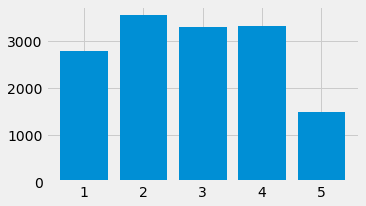

In [8]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (5,3))
ax.bar(list(Counter(y).keys()),list(Counter(y).values()))
plt.show()

In [9]:
# Split test and training
X_train, X_test, y_train, y_test = train_test_split(X, 
                                            y, test_size = 0.4, random_state = 112)
X_val, X_test, y_val, y_test = train_test_split(X_test, 
                                            y_test, test_size = 0.5, random_state = 112)

### Bayesian Search: Feature Selection <a id = 'selection'></a>

In [10]:
X = sm.add_constant(X_train)
ols = sm.OLS(y_train, X)
result=ols.fit()

In [11]:
# Baseline for training set
print(result.rsquared)

0.3333901990937542


In [12]:
# Create rsquared function
def rsquared(y_pred, y_true):
    RSS = sum((y_true - y_pred)**2)
    TSS = sum((y_true - np.mean(y_true))**2)
    return 1 - RSS/TSS

# Create adjusted rsquared function
def adjusted_r2(predict, true, params):
    r2 = rsquared(predict, true) # r_2
    n = len(true)                     # number of rows
    k = len(params)         # number oeters
    
    adj_r2 = 1 - ((1-r2)*(n-1))/(n-k-1)    # 1 - [(1 - r_2)*(n - 1)/(n - k - 1)] = adjusted r^2
    
    return adj_r2

# Create MAE function
def mae(y_pred, y_true):
    return sum(np.abs(y_pred - y_true))/len(y_true)

# Create RMSE function
def rmse(predicted, true):
    mse = sum((true - predicted)**2)/len(true)
    return mse**0.5

In [13]:
1-((1-0.3254)*(len(X)-1))/(len(X)-len(X.columns)-1)

0.322511087962963

In [14]:
# Baseline for val set
X = sm.add_constant(X_val)
print(rsquared(result.predict(X),y_val))

0.3419197807828842


In [15]:
# Feature selection automation
def vectorize_selection(thelist):
    empty = []
    for i in range(len(X_train.columns)):
        if thelist[i] == "1":
            empty.append(X_train.columns[i])
    return empty  

# decimal to binary converter
def decimaltobinary(n):
    string = bin(n).replace("0b", "")
    return string.zfill(len(X_train.columns))

In [16]:
def feature_selection_eval(n):
    # Convert value into binary
    result = list(decimaltobinary(int(round(n))))
    # Automate to select features using vector
    selected = vectorize_selection(result)
    
    # Fit logit function using selected features
    X = sm.add_constant(X_train[selected])
    ols = sm.OLS(y_train, X)
    result = ols.fit()
    
    RSS = sum((y_train - result.predict(X))**2)
    TSS = sum((y_train - np.mean(y_train))**2)
    r2 = 1 - RSS/TSS
    
    return r2 

In [17]:
def best_columns(n):
    # Convert value into binary
    result = list(decimaltobinary(int(round(n))))
    # Automate to select features using vector
    selected = vectorize_selection(result)
    return selected

In [18]:
# Instantiate Bayesian Optimization  
import warnings    
warnings.simplefilter("ignore")
selection_BO = BayesianOptimization(feature_selection_eval, {'n':(0,2**len(X_train.columns))})
selection_BO.maximize(n_iter=100, init_points=5)

|   iter    |  target   |     n     |
-------------------------------------
|  1        |  0.3128   |  3.184e+1 |
|  2        |  0.3109   |  1.7e+10  |
|  3        |  0.315    |  3.437e+1 |
|  4        |  0.2543   |  5.605e+0 |
|  5        |  0.2975   |  6.788e+1 |
|  6        |  0.2897   |  5.597e+1 |
|  7        |  0.3209   |  4.719e+1 |
|  8        |  0.2322   |  2.385e+1 |
|  9        |  0.3047   |  6.47e+10 |
|  10       |  0.3188   |  9.527e+0 |
|  11       |  0.3003   |  3.295e+1 |
|  12       |  0.3187   |  2.515e+0 |
|  13       |  0.2505   |  3.706e+1 |
|  14       |  0.2713   |  1.778e+0 |
|  15       |  0.307    |  6.695e+0 |
|  16       |  0.2752   |  3.397e+1 |
|  17       |  0.2422   |  4.58e+10 |
|  18       |  0.2799   |  4.133e+1 |
|  19       |  0.288    |  2.791e+1 |
|  20       |  0.3182   |  4.469e+1 |
|  21       |  0.2782   |  6.747e+1 |
|  22       |  0.3115   |  4.468e+1 |
|  23       |  0.2812   |  6.486e+1 |
|  24       |  0.2957   |  8.929e+0 |
|  25       

In [19]:
display(best_columns(selection_BO.max['params']['n']))

['Provider Zip Code',
 'Number of Certified Beds',
 'Average Number of Residents per Day',
 'Reported LPN Staffing Hours per Resident per Day',
 'Reported Licensed Staffing Hours per Resident per Day',
 'Reported Total Nurse Staffing Hours per Resident per Day',
 'Reported Physical Therapist Staffing Hours per Resident Per Day',
 'Case-Mix Nurse Aide Staffing Hours per Resident per Day',
 'Case-Mix LPN Staffing Hours per Resident per Day',
 'Adjusted Nurse Aide Staffing Hours per Resident per Day',
 'Adjusted LPN Staffing Hours per Resident per Day',
 'Adjusted RN Staffing Hours per Resident per Day',
 'Adjusted Total Nurse Staffing Hours per Resident per Day',
 'Number of Facility Reported Incidents',
 'Number of Substantiated Complaints',
 'Number of Fines',
 'Total Amount of Fines in Dollars',
 'Number of Payment Denials',
 'Total Number of Penalties',
 'Provider Type: Medicare and Medicaid',
 'Abuse Icon',
 'Automatic Sprinkler Systems in All Required Areas: Partial']

In [20]:
X = sm.add_constant(X_train[best_columns(selection_BO.max['params']['n'])])
ols = sm.OLS(y_train, X)
result = ols.fit()
pd.options.display.float_format = '{:.4f}'.format
display(pd.DataFrame(result.params).merge(pd.DataFrame(result.pvalues), left_index=True, 
            right_index=True).rename(columns = {'0_x':'parameters',
            '0_y':'p_values'}).sort_values('parameters'))

,parameters,p_values
Abuse Icon,-0.6328,0.0000
Case-Mix LPN Staffing Hours per Resident per Day,-0.3759,0.2903
Reported LPN Staffing Hours per Resident per Day,-0.3224,0.1566
Provider Type: Medicare and Medicaid,-0.2265,0.0000
Reported Total Nurse Staffing Hours per Resident per Day,-0.1665,0.4249
Total Number of Penalties,-0.1474,0.0000
Number of Payment Denials,-0.1118,0.0000
Number of Fines,-0.0356,0.0108
Number of Substantiated Complaints,-0.0344,0.0000
Number of Facility Reported Incidents,-0.0327,0.0000


### Comparsion between Bayes Optimal and Lasso Feature Selection <a id='lasso'></a>

In [21]:
print('R2 for Bayes Optimal Feature Selection is '+str(round(100*result.rsquared,2))+'%')

R2 for Bayes Optimal Feature Selection is 33.22%


In [22]:
lasso = Lasso(alpha=0.005)
lasso.fit(X_train,y_train)

Lasso(alpha=0.005)

In [23]:
float_formatter = "{:.5f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
regul = pd.Series(lasso.coef_,index = X_train.columns)
print(regul[(regul > 0.0001) | (regul < -0.0001)])

Provider Zip Code                                           0.0165
Number of Certified Beds                                   -0.0023
Average Number of Residents per Day                         0.0017
Reported Total Nurse Staffing Hours per Resident per Day    0.1129
Case-Mix Nurse Aide Staffing Hours per Resident per Day     0.4401
Adjusted Nurse Aide Staffing Hours per Resident per Day    -0.0293
Adjusted RN Staffing Hours per Resident per Day             0.2152
Number of Facility Reported Incidents                      -0.0329
Number of Substantiated Complaints                         -0.0353
Number of Payment Denials                                  -0.0448
Total Number of Penalties                                  -0.1865
Provider Type: Medicare and Medicaid                       -0.1227
Continuing Care Retirement Community                        0.0244
Abuse Icon                                                 -0.5136
non profit                                                  0.

In [24]:
# Best features to explain
X = sm.add_constant(X_train[regul[(regul > 0.0001) | (regul < -0.0001)].index])
ols = sm.OLS(y_train, X)
l_result = ols.fit()
pd.options.display.float_format = '{:.4f}'.format
explained_result = pd.DataFrame(l_result.params).merge(pd.DataFrame(l_result.bse), left_index=True, 
            right_index=True).merge(pd.DataFrame(l_result.HC0_se),left_index=True, 
            right_index=True).rename(columns = {'0_x':'parameters',
            '0_y':'se',0:'robust se'}).sort_values('parameters')

# Save this info for report
explained_result.to_csv('explained_result')

In [25]:
display(explained_result)

,parameters,se,robust se
Abuse Icon,-0.6923,0.0570,0.0446
Provider Type: Medicare and Medicaid,-0.2474,0.0551,0.0555
Total Number of Penalties,-0.2277,0.0099,0.0135
Number of Payment Denials,-0.0749,0.0366,0.0370
Number of Substantiated Complaints,-0.0355,0.0016,0.0028
Number of Facility Reported Incidents,-0.0328,0.0036,0.0039
Adjusted Nurse Aide Staffing Hours per Resident per Day,-0.0138,0.0327,0.0341
Number of Certified Beds,-0.0023,0.0004,0.0009
Average Number of Residents per Day,0.0017,0.0006,0.0011
Provider Zip Code,0.0229,0.0046,0.0047


In [26]:
# Check 
test = het_breuschpagan(l_result.resid, l_result.model.exog)
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']

In [27]:
for i in enumerate(names):
    print(i[1],test[i[0]])

Lagrange multiplier statistic 165.8195702677018
p-value 1.6847262952674067e-27
f-value 11.249206393243716
f p-value 8.743858948723349e-28


Breusch Pagan test said that heteroskedasticity exists, so using robust se instead.

In [28]:
print('R2 for Lasso Feature Selection is '+str(round(100*l_result.rsquared,2))+'%')
print('R2 for Bayes Optimal Feature Selection is '+str(round(100*result.rsquared,2))+'%')

R2 for Lasso Feature Selection is 32.19%
R2 for Bayes Optimal Feature Selection is 33.22%


In [29]:
print('Number of Columns for Lasso:',len(l_result.params))
print('Number of Columns for Bayes:',len(result.params))

Number of Columns for Lasso: 16
Number of Columns for Bayes: 23


In [30]:
features = list(l_result.params.index)
features.remove('const')
X = sm.add_constant(X_val[features])
print('MAE for Lasso:',mae(l_result.predict(X),y_val))

MAE for Lasso: 0.8543762137640284


In [31]:
X = sm.add_constant(X_val[best_columns(selection_BO.max['params']['n'])])
print('MAE for Bayes:',mae(result.predict(X),y_val))

MAE for Bayes: 0.8491697643038564


The efficiency of lasso regularization is superior to that of Bayes optimal feature selection. 

In [32]:
# Exogenous variables use best features
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

### Light Gradient Boosting Model With Bayesian Optimization <a id='lgbm'></a>

In [33]:
# Because LGBM_eval does not tolerate with special characters
# Replace ':' with '', ' ' with '_', and '-' with '_'
X_train.columns = X_train.columns.str.replace(':'
                    ,'').str.replace(' ','_').str.replace('-','_')
X_val.columns = X_val.columns.str.replace(':'
                    ,'').str.replace(' ','_').str.replace('-','_')
X_test.columns = X_test.columns.str.replace(':'
                    ,'').str.replace(' ','_').str.replace('-','_')

In [34]:
def lgbm_eval(max_depth,learning_rate,n_estimators):
    lgbm_model = LGBMRegressor(max_depth = int(round(max_depth,0)),
                                reg_lambda = 0,
                                reg_alpha = 0,
                                learning_rate = learning_rate, 
                                n_estimators = int(round(n_estimators,0)))
     
    lgbm_model.fit(X_train, y_train)
    return lgbm_model.score(X_val,y_val)

In [35]:
def eval(max_depth, learning_rate, n_estimators):
    lgbm_model = LGBMRegressor(max_depth = max_depth,
                                    learning_rate = learning_rate, 
                                    n_estimators = n_estimators)
    lgbm_model.fit(X_train, y_train)
    return lgbm_model.score(X_val,y_val)

In [36]:
learn = []
max_depth = []
n_est = []
for i in range(99):
    learn.append(eval(10,(i+1)/100,10))
for i in range(20):
    max_depth.append(eval(i+1,0.9,10))
for i in range(20):
    n_est.append(eval(10,0.9,i+1))

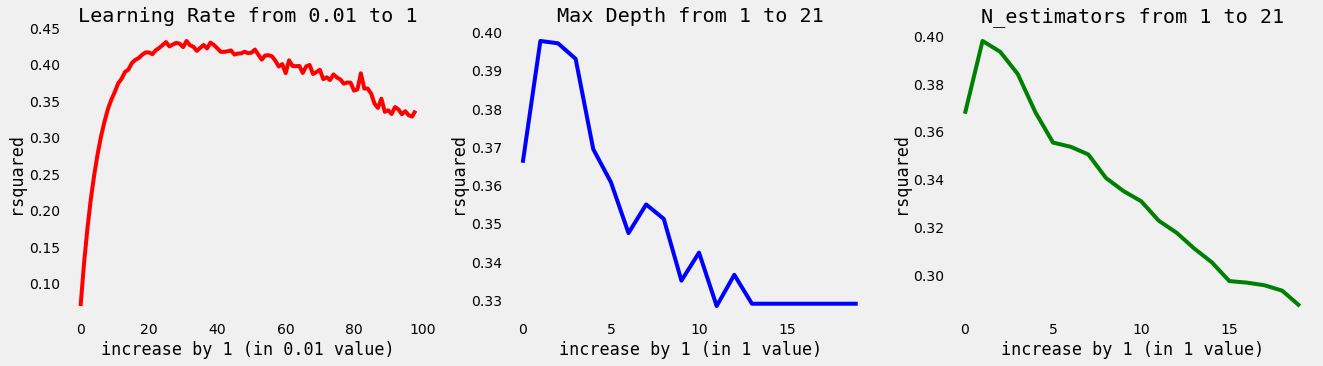

In [37]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
ax[0].plot(learn, color = 'red')
ax[1].plot(max_depth, color = 'blue')
ax[2].plot(n_est, color = 'green')
xtitle = ['increase by 1 (in 0.01 value)','increase by 1 (in 1 value)', 'increase by 1 (in 1 value)']
title = ['Learning Rate from 0.01 to 1','Max Depth from 1 to 21','N_estimators from 1 to 21']
for i in range(3):
    ax[i].set_ylabel('rsquared', family = 'monospace')
    ax[i].set_xlabel(xtitle[i],family='monospace')
    ax[i].set_title(title[i],family = 'monospace')
    ax[i].grid(False)
plt.show()

In [38]:
lgbmBO = BayesianOptimization(lgbm_eval, {'max_depth':(2,10),
                                          'learning_rate':(0.01,0.5),
                                          'n_estimators':(5,20)})

lgbmBO.maximize(n_iter=20, init_points=5)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
|  1        |  0.4098   |  0.09938  |  5.649    |  19.2     |
|  2        |  0.4086   |  0.1515   |  5.639    |  11.59    |
|  3        |  0.419    |  0.3263   |  3.311    |  13.48    |
|  4        |  0.4142   |  0.4763   |  6.558    |  10.48    |
|  5        |  0.3895   |  0.1993   |  6.449    |  7.036    |
|  6        |  0.4272   |  0.3622   |  2.606    |  14.56    |
|  7        |  0.07952  |  0.01     |  2.0      |  16.4     |
|  8        |  0.4096   |  0.5      |  2.0      |  13.48    |
|  9        |  0.427    |  0.285    |  4.833    |  9.822    |
|  10       |  0.4252   |  0.5      |  3.476    |  11.12    |
|  11       |  0.05474  |  0.01     |  2.904    |  9.254    |
|  12       |  0.4182   |  0.5      |  4.248    |  12.19    |
|  13       |  0.06242  |  0.01     |  6.226    |  8.903    |
|  14       |  0.4264   |  0.4116   |  4.609    |  10.95    |
|  15   

In [39]:
print(lgbmBO.max['params'])

{'learning_rate': 0.21709987259257918, 'max_depth': 9.931503257823692, 'n_estimators': 19.104951856713882}


In [40]:
best_lgbm_model = LGBMRegressor(max_depth = int(round(lgbmBO.max['params']['max_depth'])),
                                learning_rate = lgbmBO.max['params']['learning_rate'], 
                                n_estimators = int(round(lgbmBO.max['params']['n_estimators'])))
best_lgbm_model.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.21709987259257918, max_depth=10, n_estimators=19)

In [41]:
print('Validation R2 Score:',rsquared(best_lgbm_model.predict(X_val),y_val))
print('Validation Adjusted R2 Score:',adjusted_r2(best_lgbm_model.predict(X_val),y_val,X_val.columns))
print('Validation RMSE score:',rmse(best_lgbm_model.predict(X_val),y_val))
print('Validation MAE score:',mae(best_lgbm_model.predict(X_val),y_val))

Validation R2 Score: 0.4334481878525891
Validation Adjusted R2 Score: 0.43049432021886946
Validation RMSE score: 0.9541589734782361
Validation MAE score: 0.7737673852732686


In [42]:
print('Testing R2 Score:',rsquared(best_lgbm_model.predict(X_test),y_test))
print('Testing Adjusted R2 Score:',adjusted_r2(best_lgbm_model.predict(X_test),y_test,X_test.columns))
print('Testing RMSE score:',rmse(best_lgbm_model.predict(X_test),y_test))
print('Testing MAE score:',mae(best_lgbm_model.predict(X_test),y_test))

Testing R2 Score: 0.41945677334071074
Testing Adjusted R2 Score: 0.41642995776897307
Testing RMSE score: 0.9642217419638864
Testing MAE score: 0.7665421173508036


### Shapley Additive Explanations <a id = 'shap'></a>

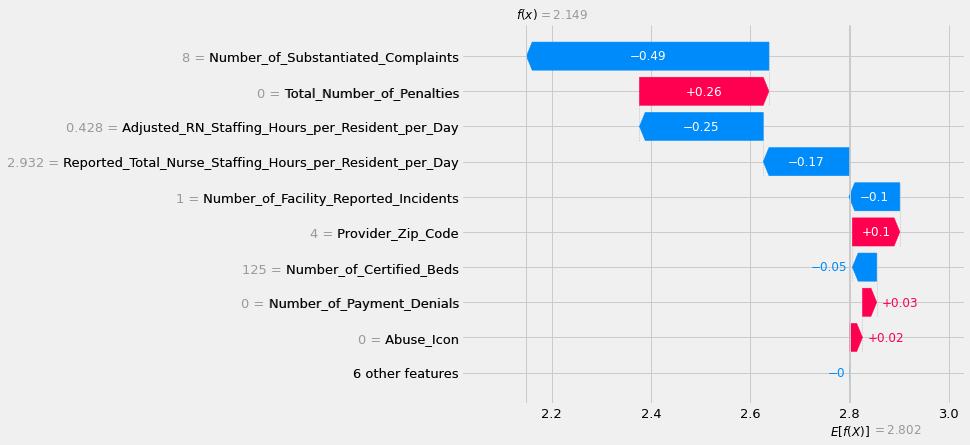

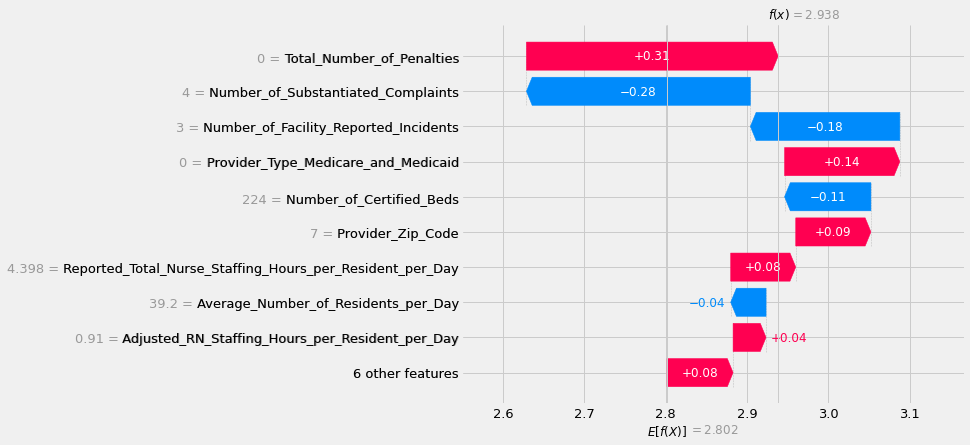

In [43]:
# explain the LGBM model predictions using SHAP
explainer = shap.Explainer(best_lgbm_model)
shap_values = explainer(X_train)

# First one
shap.plots.waterfall(shap_values[0])
shap.plots.waterfall(shap_values[1000])

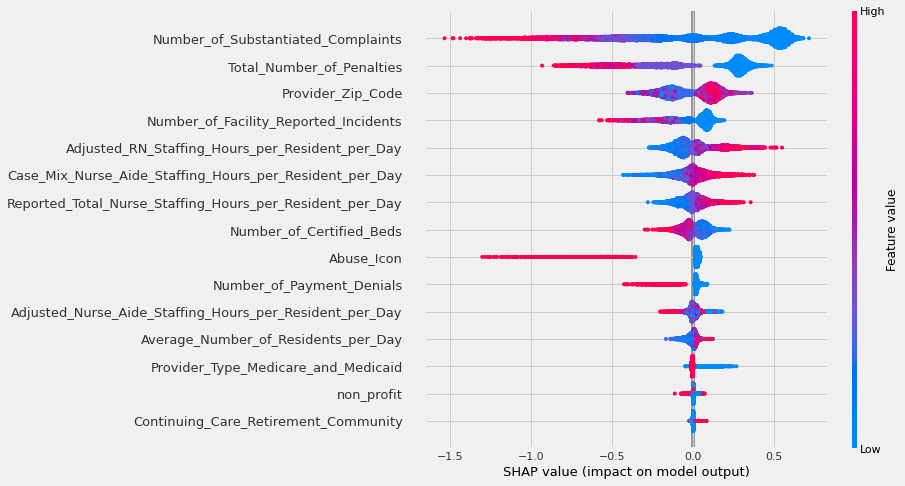

In [44]:
# visualize the first prediction's explanation
shap.summary_plot(shap_values, X_train)

### Economic Approach <a id = 'econ'></a>

Gauss Markov Assumption:

- Depart from A1. Linearity in parameters.
- A2. No perfect collinearity.
- A3. Zero conditional mean error.
- Depart from A4. Homoskedasticity and no serial correlation.
- A5. Normality of the error.

Causal equation: 

- ins_rat = Health Inspection Rating
- hr = Hours Per Residents Per Day
- abu = Abuse Icon
- lpn = LPN
- rn = RN
- nur = Nurse Aid
- repor = Number of Facility Reported Incidents
- compl = Number of Substantiated Complaints
- fin = Number of Fines
- fam = With a Resident and Family Council: Family
- spri = Automatic Sprinkler Systems in All Required Areas: Yes
- amou = Total Amount of Fines in Dollars 
- bed = Number of Certified Beds
- zip = National Area regional code
- f(*) = Probit Regression

ins_rat = f(intercept + B0 * bed + B1 * hr + B2 * competency + B3 * quality + B4* vulnerability + B5 * location) + error

- competency: proxies = nur + rn + lpn
- quality: proxies = fin + spri + amou + compl + repor
- vulnerability: proxies = fam + abu
- geography: proxy = zip

In [45]:
# Select factors and effect
names = ['Health Inspection Rating',
         'Provider Zip Code',
         'Number of Certified Beds',
         'Adjusted Nurse Aide Staffing Hours per Resident per Day',
         'Adjusted LPN Staffing Hours per Resident per Day',
         'Adjusted RN Staffing Hours per Resident per Day',
         'Adjusted Total Nurse Staffing Hours per Resident per Day',
         'Number of Facility Reported Incidents',
         'Number of Substantiated Complaints', 
         'Number of Fines',
         'Abuse Icon',
         'With a Resident and Family Council: Family',
         'Automatic Sprinkler Systems in All Required Areas: Yes',
         'Total Amount of Fines in Dollars']
df = df[names]

In [46]:
# min max scaling
minmax = MinMaxScaler()
df['Health Inspection Rating'] = minmax.fit_transform(np.array(df['Health Inspection Rating']).reshape(-1,1))

In [47]:
# Create the proxy: competency 
df = pd.melt(df, id_vars =['Health Inspection Rating',
                      'Provider Zip Code',
                      'Number of Certified Beds',
                      'Number of Facility Reported Incidents',
                      'Number of Substantiated Complaints', 
                      'Number of Fines',
                      'Abuse Icon',
                      'With a Resident and Family Council: Family',
                      'Automatic Sprinkler Systems in All Required Areas: Yes',
                      'Total Amount of Fines in Dollars'], 
        value_vars =['Adjusted Nurse Aide Staffing Hours per Resident per Day',
                     'Adjusted LPN Staffing Hours per Resident per Day',
                     'Adjusted RN Staffing Hours per Resident per Day',
                     'Adjusted Total Nurse Staffing Hours per Resident per Day'])

df = pd.concat([df,pd.get_dummies(df['variable'])],axis=1).drop(
    ['variable','Adjusted Total Nurse Staffing Hours per Resident per Day'], axis = 1).rename(
    columns = {'value':'Adjusted Hours per Resident per Day',
               'Adjusted LPN Staffing Hours per Resident per Day':'LPN',
               'Adjusted Nurse Aide Staffing Hours per Resident per Day':'Nurse Aide',
               'Adjusted RN Staffing Hours per Resident per Day':'RN'})

In [48]:
# Drop 0.5
df = df[df['Health Inspection Rating'] != 0.5]
# Change from 0, 0.25, 0.75, and 1 to 0 and 1, and from float to integer
df['Health Inspection Rating'] = df['Health Inspection Rating'].apply(lambda x: 0 
                                                                      if x <= 0.25 else 1).astype('int')

In [49]:
# Applied
y = df['Health Inspection Rating']
X = sm.add_constant(df.drop('Health Inspection Rating',axis=1))

In [50]:
probit = sm.Probit(y, X)
result = probit.fit()

Optimization terminated successfully.
         Current function value: 0.445967
         Iterations 30


In [51]:
display(result.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Probit Regression Results                              
====================================================================================
Dep. Variable:     Health Inspection Rating   No. Observations:                44628
Model:                               Probit   Df Residuals:                    44614
Method:                                 MLE   Df Model:                           13
Date:                      Sun, 10 Oct 2021   Pseudo R-squ.:                  0.3476
Time:                              19:43:47   Log-Likelihood:                -19903.
converged:                             True   LL-Null:                       -30508.
Covariance Type:                  nonrobust   LLR p-value:                     0.000
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
const                                                     -0.1167      0.160     -0.731      0.465      -0.430       0.196
Provider Zip Code                                          0.0385      0.003     13.705      0.000       0.033       0.044
Number of Certified Beds                                  -0.0016      0.000    -12.649      0.000      -0.002      -0.001
Number of Facility Reported Incidents                     -0.0811      0.004    -20.413      0.000      -0.089      -0.073
Number of Substantiated Complaints                        -0.1626      0.003    -61.423      0.000      -0.168      -0.157
Number of Fines                                           -0.3205      0.009    -34.965      0.000      -0.338      -0.303
Abuse Icon                                               -10.5480   4.92e+08  -2.14e-08      1.000   -9.64e+08    9.64e+08
With a Resident and Family Council: Family                 0.5775      0.184      3.137      0.002       0.217       0.938
Automatic Sprinkler Systems in All Required Areas: Yes     0.1068      0.152      0.705      0.481      -0.190       0.404
Total Amount of Fines in Dollars                       -9.307e-06    3.6e-07    -25.829      0.000      -1e-05    -8.6e-06
Adjusted Hours per Resident per Day                        0.1750      0.011     16.269      0.000       0.154       0.196
LPN                                                        0.5598      0.040     14.043      0.000       0.482       0.638
Nurse Aide                                                 0.3074      0.028     11.071      0.000       0.253       0.362
RN                                                         0.5812      0.041     14.145      0.000       0.501       0.662
==========================================================================================================================

Possibly complete quasi-separation: A fraction 0.11 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [52]:
# Check 
test = het_breuschpagan(result.resid_generalized, result.model.exog)
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']

for i in enumerate(names):
    print(i[1],test[i[0]])

Lagrange multiplier statistic 1214.8994556617242
p-value 1.1014534374858623e-251
f-value 96.03893690947669
f p-value 2.9375342160012796e-255


In [53]:
print(result.wald_test(['Abuse Icon','Automatic Sprinkler Systems in All Required Areas: Yes'],use_f=False))
print(result.wald_test(['Automatic Sprinkler Systems in All Required Areas: Yes'],use_f=False))

<Wald test (chi2): statistic=[[0.00000]], p-value=0.9999999828894759, df_denom=1>
<Wald test (chi2): statistic=[[0.49681]], p-value=0.4809064294205787, df_denom=1>


In [54]:
results = IV2SLS(y, X['Abuse Icon'], X['Automatic Sprinkler Systems in All Required Areas: Yes']).fit()

thelist = ['H','pval','dof']
for i in enumerate(results.spec_hausman()):
    print(thelist[i[0]],i[1])

NameError: name 'IV2SLS' is not defined

In [ ]:
# Remove Abuse Icon
y = df['Health Inspection Rating']
X = sm.add_constant(df.drop(['Health Inspection Rating','Abuse Icon',
                             'Automatic Sprinkler Systems in All Required Areas: Yes'],axis=1))
probit = sm.Probit(y, X)
result = probit.fit(cov_type="hc0")

In [ ]:
display(result.summary())

In [ ]:
# Check 
test = het_breuschpagan(result.resid_generalized, result.model.exog)
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']

for i in enumerate(names):
    print(i[1],test[i[0]])

In [ ]:
table = pd.concat([pd.DataFrame(result.params).rename(columns = {0:'coef'}),result.conf_int()],axis=1).rename(
    columns = {0:0.025,1:0.975})

In [ ]:
table.index = ['intercept', 'National Area regional code', 'Number of Certified Beds',
               'Number of Facility Reported Incidents',
               'Number of Substantiated Complaints','Number of Fines',
               'Family',
               'Total Amount of Fines in Dollars',
               'Adjusted Hours per Resident per Day','LPN', 'Nurse Aide', 'RN']

In [ ]:
table.to_csv('actionable')

In [ ]:
X = X.drop(['Automatic Sprinkler Systems in All Required Areas: Yes','Abuse Icon'],axis=1)

In [ ]:
X.columns = ['cons','zip','bed','repor','compl','fine','fam','amou','hr','lpn','nur_aid','rn']

In [ ]:
data = pd.concat([y,X],axis=1).rename(columns = {'Health Inspection Rating':'ins_rat'})

In [ ]:
import statsmodels.formula.api as smf

In [ ]:
formula = 'ins_rat ~ zip + bed + hr + repor + compl + fine + fam + amou + hr*nur_aid + hr*lpn + hr*rn'
result = smf.probit(formula = formula,data=data).fit()
result._get_robustcov_results("HC0")

In [ ]:
display(result.summary())

In [ ]:
print(result.wald_test(['hr:lpn','hr:rn','hr:nur_aid']))

In [ ]:
formula = 'ins_rat ~ zip + bed + hr + repor + compl + fine + fam + amou + bed*fam'
result = smf.probit(formula = formula,data=data).fit()
result._get_robustcov_results("HC0")

In [ ]:
display(result.summary())

In [ ]:
print(result.wald_test(['bed:fam']))